<a href="https://colab.research.google.com/github/akpax/RandomForestHousePrice/blob/main/House_prices_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00
Mounted at /content/gdrive


# House Prices Kaggle
Applying material learned in tabular data cahopter in fast ai to housing prices kaggle dataset

## Access Data and Process for input

In [ ]:
cred = ''
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
! kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 87.6MB/s]


In [ ]:
! unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [278]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [279]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,...,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,...,2008,WD,Normal,208500
1,2,20,RL,80.0,...,2007,WD,Normal,181500
2,3,60,RL,68.0,...,2008,WD,Normal,223500
3,4,70,RL,60.0,...,2006,WD,Abnorml,140000
4,5,60,RL,84.0,...,2008,WD,Normal,250000


### Handle Ordinal Columns

In [280]:
train.LandSlope.unique()

array(['Gtl', 'Mod', 'Sev'], dtype=object)

In [281]:
def set_ordinal(dfs, feature_order_dict):
  out_dfs = []
  for df in dfs:
    for feature, ordered_list in feature_order_dict.items():
      print(feature)
      df[feature] = df[feature].astype("category")
      df[feature].cat.set_categories(ordered_list, ordered=True, inplace=True)
    out_dfs.append(df)
  return out_dfs

In [282]:
ordinal_feature_dict = {
    "LandSlope": ["Gtl", "Mod", "Sev"],
    "ExterQual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "BsmtQual": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "BsmtCond": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "BsmtExposure": ["Gd", "Av", "Mn", "No", "NA"],
    "BsmtFinType1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"],
    "BsmtFinType2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"],
    "HeatingQC": ["Ex", "Gd", "TA", "Fa",   "Po"],
    "KitchenQual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "FireplaceQu": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "GarageFinish": ["Fin", "rFn", "Unf", "NA"],
    "GarageQual": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "GarageCond": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "PavedDrive": ["Y", "P", "N"],
    "PoolQC": ["Ex", "Gd", "TA", "Fa", "NA"],
    "Fence": ["GdPrv", "MnPrv", "GdWo", "MnWw","NA"]
}

In [283]:
train,test = set_ordinal([train, test], ordinal_feature_dict)

LandSlope
ExterQual
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
HeatingQC
KitchenQual
FireplaceQu
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
LandSlope
ExterQual
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
HeatingQC
KitchenQual
FireplaceQu
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence


<ipython-input-281-9d3775f2d1fc>:7: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
<ipython-input-281-9d3775f2d1fc>:7: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
<ipython-input-281-9d3775f2d1fc>:7: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
<ipython-input-281-9d3775f2d1fc>:7: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
<ipython-input-281-9d3775f2d1fc>:7: FutureWa

### One Hot encode date data

In [ ]:
"""
This is not necessary because we only have year data
If we had dates this would be a crucial step
"""

# def apply_to_dfs(func):
#   def wrapper(dfs, *args, **kwargs):
#       return [func(df,*args, **kwargs) for df in dfs]
#   return wrapper

# @apply_to_dfs
# def add_date_parts(df, date_list ):
#   for date in date_list:
#     df = add_datepart(df,date)


# train,test = add_date_parts([train,test], ["YearBuilt", 'YearRemodAdd'])



'\nThis is not necessary because we only have year data\nIf we had dates this would be a crucial step\n'

### Load Data into Fastai TabularPandas and use Tabular procedures to categorify and fill missing values

In [284]:
procs = [Categorify, FillMissing]


In [285]:
# create splits for tabular df
idx = train.index
idx_rand = np.random.permutation(idx)
n_train = round((len(idx_rand)*0.8))
splits = (list(idx_rand[:n_train]), list(idx_rand[n_train:]))


assert len(splits[0]) +len(splits[1]) == len(idx_rand)

In [286]:
# use cont_cat_split to determine continuous and categorical columns
cont,cat = cont_cat_split(train,1, dep_var="SalePrice")
print(cont)
print(cat)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'Gar

In [287]:
to = TabularPandas(train, procs, cat, cont, y_names="SalePrice", splits=splits)

In [ ]:
print(len(to.train),len(to.valid))

1168 292


In [ ]:
to.show()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
371,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,ClearCr,Feedr,Norm,1Fam,1.5Fin,Gable,CompShg,WdShing,Plywood,None,TA,TA,CBlock,#na#,#na#,#na#,#na#,#na#,GasA,TA,Y,SBrkr,TA,Min2,Gd,Detchd,Fin,TA,TA,N,#na#,#na#,#na#,WD,Normal,False,False,False,372,50,80.0,17120,4,4,1959,1959,0.0,0,0,0,0,1120,468,0,1588,0,0,2,0,4,1,7,1,1991.0,2,680,0,59,0,0,0,0,0,7,2008,134432
44,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,BrkFace,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,ALQ,BLQ,GasA,Ex,Y,FuseA,TA,Typ,#na#,Attchd,#na#,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,45,20,70.0,7945,5,6,1959,1959,0.0,179,506,465,1150,1150,0,0,1150,1,0,1,0,3,1,6,0,1959.0,1,300,0,0,0,0,0,0,0,5,2006,141000
696,RM,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,CBlock,TA,TA,No,LwQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,#na#,Detchd,Unf,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,697,30,50.0,6000,5,7,1921,1950,0.0,616,0,0,616,616,0,0,616,0,0,1,0,2,1,4,0,1921.0,1,205,0,0,129,0,0,0,0,6,2006,89000
698,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,RRAe,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,Gd,CBlock,TA,TA,No,GLQ,BLQ,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,TA,TA,Y,#na#,MnPrv,#na#,WD,Normal,False,False,False,699,20,65.0,8450,5,8,1965,2009,0.0,553,117,224,894,894,0,0,894,1,0,1,0,3,1,5,1,1973.0,1,336,416,144,0,0,0,0,0,4,2010,138500
1010,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,1011,50,115.0,21286,5,5,1948,1950,0.0,0,0,720,720,720,551,0,1271,0,0,2,0,4,1,7,1,1948.0,1,312,0,0,108,0,0,0,0,8,2008,135000
80,RL,Pave,#na#,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,Gd,CBlock,Gd,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,81,60,100.0,13000,6,6,1968,1968,576.0,448,0,448,896,1182,960,0,2142,0,0,2,1,4,1,8,1,1968.0,1,509,0,72,0,0,252,0,0,6,2009,193500
336,RL,Pave,#na#,IR1,HLS,AllPub,Corner,Gtl,StoneBr,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,Stone,Gd,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,337,20,86.0,14157,9,5,2005,2006,200.0,1249,0,673,1922,1922,0,0,1922,1,0,2,0,3,1,8,1,2005.0,3,676,178,51,0,0,0,0,0,7,2007,377426
1139,RL,Pave,#na#,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,Gable,CompShg,Stucco,Stucco,None,TA,Fa,BrkTil,TA,TA,No,BLQ,Unf,GasA,TA,Y,SBrkr,TA,Maj1,Gd,Detchd,Unf,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,1140,30,98.0,8731,5,5,1920,1950,0.0,645,0,270,915,1167,0,0,1167,0,0,1,0,3,1,6,1,1972.0,2,495,0,0,216,0,126,0,0,5,2007,144000
1134,RL,Pave,#na#,IR1,HLS,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,Av,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,1135,60,57.0,8773,6,5,1997,1997,0.0,0,0,916,916,916,684,0,1600,0,0,2,1

In [ ]:
# check classes
to.classes["LandSlope"]

['#na#', 'Gtl', 'Mod', 'Sev']

In [ ]:
# pickle tabular data object for later use
path = Path()
save_pickle(path/"tab_train.pkl", to)

## Build Decision Tree as Baseline

In [134]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

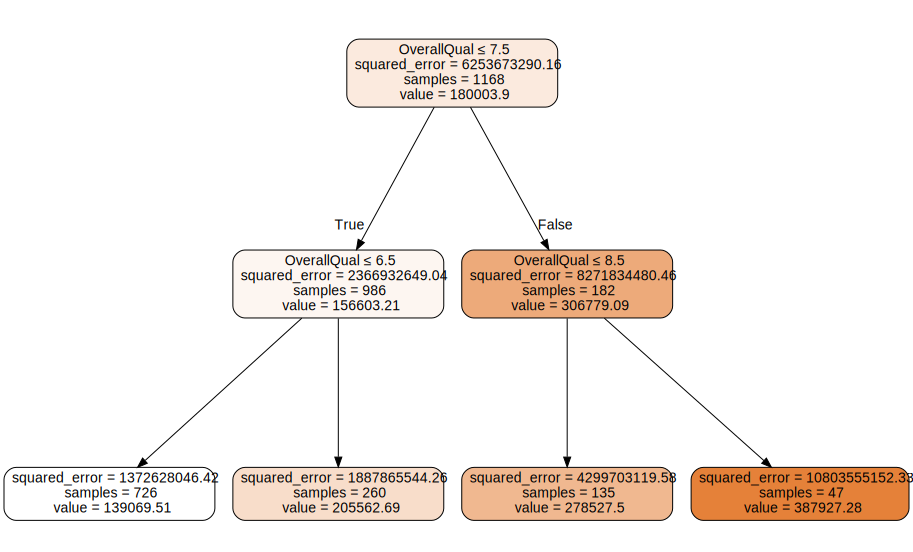

In [135]:
# build and visualize simple tree
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y)
draw_tree(m, xs, size=20,  leaves_parallel=True, precision=2)

In [136]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

In [137]:
def r_mse(pred,y):
  return round(math.sqrt(((pred-y)**2).mean()))

def m_rmse(m, xs, y):
   return r_mse(m.predict(xs), y)

In [138]:
# our decision tree overfit the data
print(m_rmse(m,xs,y))
print(m_rmse(m,valid_xs,valid_y))

0
34955


In [139]:
# prevent overfiting by specifiying num leaf nodes
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(33344, 41157)

In [133]:
m.get_n_leaves()

37

## Implement Random Forest Regressor

In [174]:
def rf(xs, y, n_estimators=40, max_samples=450,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [172]:
m = rf(xs,y)

In [173]:
print(m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y))

25356 33631


In [188]:
# test combinations of max_samples
import matplotlib.pyplot as plt

def test_hyperparam(param_name, param_range, xs,y,valid_xs,valid_y, visualize=True):
  param_val = []
  train_rmse = []
  val_rmse = []

  for i in range(len(param_range)):
    param_val.append(param_range[i])
    param_kwarg = {param_name: param_range[i]}
    m = rf(xs,y,**param_kwarg)
    train_rmse.append(m_rmse(m,xs,y))
    val_rmse.append(m_rmse(m,valid_xs,valid_y))

  if visualize:
    plt.figure(figsize=(10, 6))
    plt.plot(param_val, train_rmse, label="train rmse", color="blue")
    plt.plot(param_val, val_rmse, label="validation rmse", color="red")
      # Add a legend
    plt.legend()

    # Add title and labels
    plt.xlabel(param_name)
    plt.ylabel("Root Mean-Squarred Error")


  return param_val, train_rmse, val_rmse

[  25   50   75  100  125  150  175  200  225  250  275  300  325  350  375  400  425  450  475  500  525  550  575  600  625  650  675  700  725  750  775  800  825  850  875  900  925  950  975
 1000 1025 1050 1075 1100]


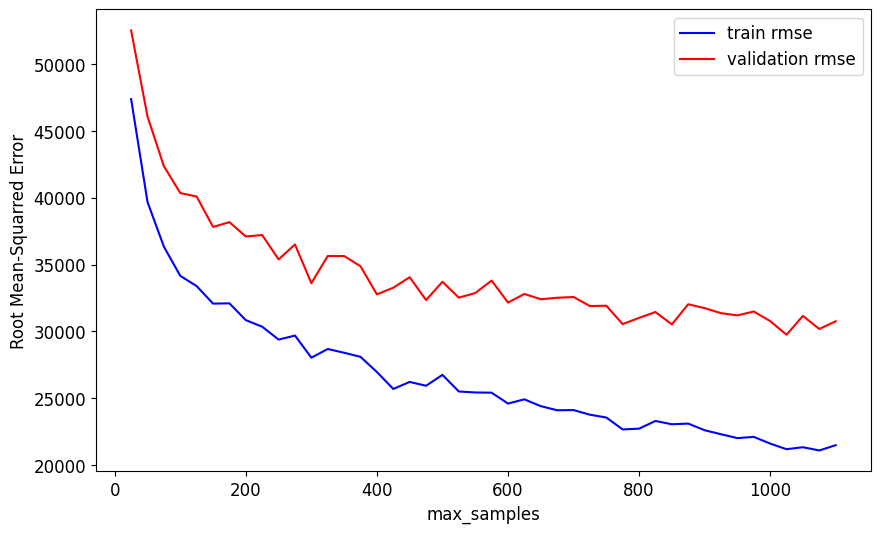

In [193]:
test_range = np.linspace(25,1100,44).astype("int")
print(test_range)
param_vals,train_rmse,val_rmse = test_hyperparam("max_samples", test_range, xs,y,valid_xs,valid_y)

In [190]:
# pick 600 for max_samples as default value because improvement is negligible on vlaidation data after this point is reached
def rf(xs, y, n_estimators=40, max_samples=450,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

[  2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98
 100]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


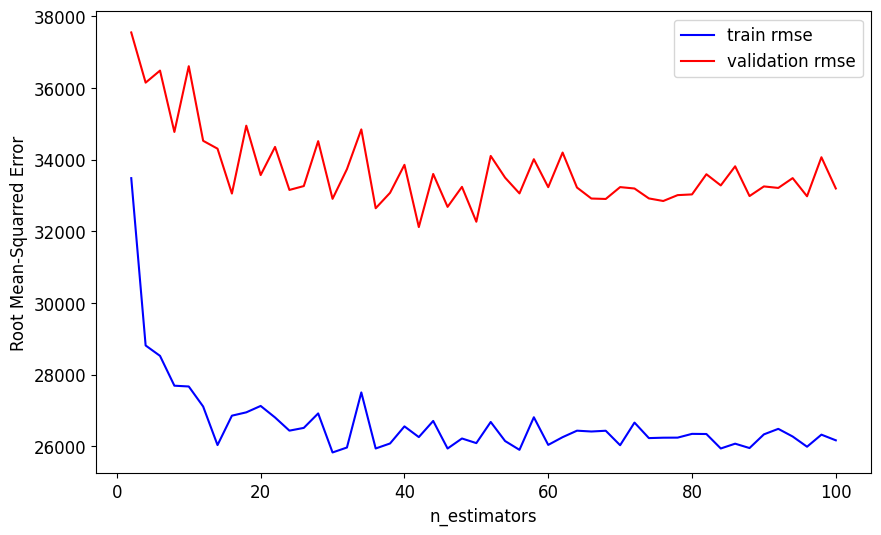

In [194]:
# check number of estimators
test_range = np.linspace(2,100,50).astype("int")
print(test_range)
param_vals,train_rmse,val_rmse = test_hyperparam("n_estimators", test_range, xs,y,valid_xs,valid_y)

In [236]:
# stick with 40 estiamtors for rf func
m = rf(xs,y,n_estimators=40,max_smaples=600)
print(m_rmse(m,xs,y))
print(m_rmse(m,valid_xs,valid_y))

26379
33400


In [199]:
# check out of bag error
r_mse(m.oob_prediction_, y)

31492

# Model Interpretation

## Tree Variance for Prediction Confidence

In [200]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X 

In [204]:
preds_std = preds.std(0)
print(preds_std)

[24421.23780791 71341.7690835  19968.78439167 28239.70632161 20710.97772739 17085.67989418 59999.28930241 36484.19818409 11362.57502892 41392.2597285  35726.12356346 15198.69034295 24596.90964067
 45364.46728341 35885.12146894 45184.1288577  19174.77102542 15146.84833358 53886.49588184 15537.71120934 39106.50011057 15010.57698069 28994.13187456 15454.92641487 17375.00052706 15925.27443121
 17327.89734951 21229.00327786 22193.47034934 34256.88826709 14513.16641064 30886.13218519 14255.85411556 26189.30594523 26562.53941207 34315.81514254 19590.6222727  89403.29806745 17332.39368304
 62276.84175636 18046.07756979 21076.92826539 14998.50950341 37532.08455007 30290.82700165 24593.89847876 29069.30975316 17828.85504077 67378.49534449 39951.00617922 43363.71987144 26281.62813972
 19046.32865986 19009.09830556 21247.09006747 23108.2757094  25348.43688584 16956.18724758 45732.61337717 20333.95557937 24583.81246527 55365.55704456 29770.23353797 11883.86226702 48544.63302626
 20799.13179435 1374

Text(0, 0.5, 'House Price with Confidence')

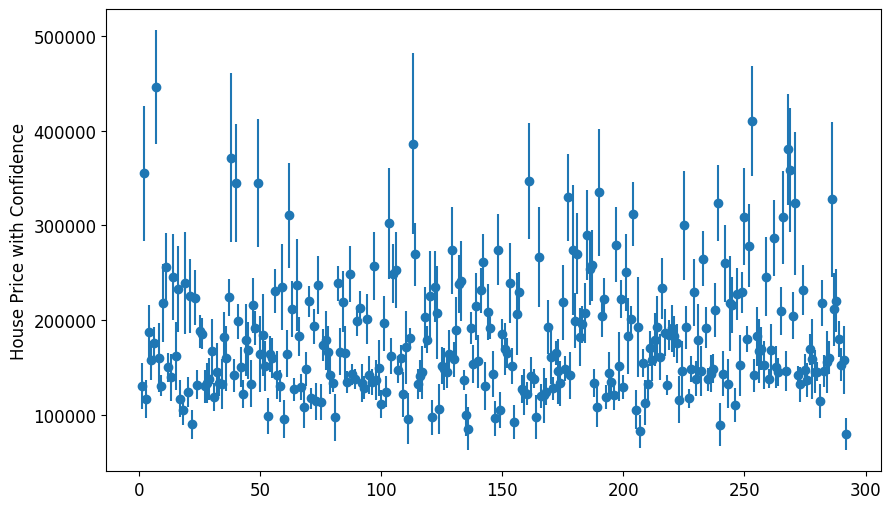

In [224]:
plt.figure(figsize=(10, 6))
y_plt = m.predict(valid_xs)
x_plt = list(range(1,len(y_plt)+1))


y_err = list(preds_std)
plt.errorbar(x_plt, y_plt, yerr=y_err, fmt="o")
plt.ylabel("House Price with Confidence")
# lower bars represent higer confidence because more trees have similar prepdictions (smaller std deviation)|

In [219]:
print(len(x_plt))
print(len(y_plt))
print(len(y_err))

291
292
292


## Feature Importance

In [225]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [226]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
50,OverallQual,0.396188
62,GrLivArea,0.110705
18,ExterQual,0.100380
72,GarageCars,0.068632
73,GarageArea,0.046000
58,TotalBsmtSF,0.041634
30,KitchenQual,0.027737
52,YearBuilt,0.023757
59,1stFlrSF,0.022925
55,BsmtFinSF1,0.022134


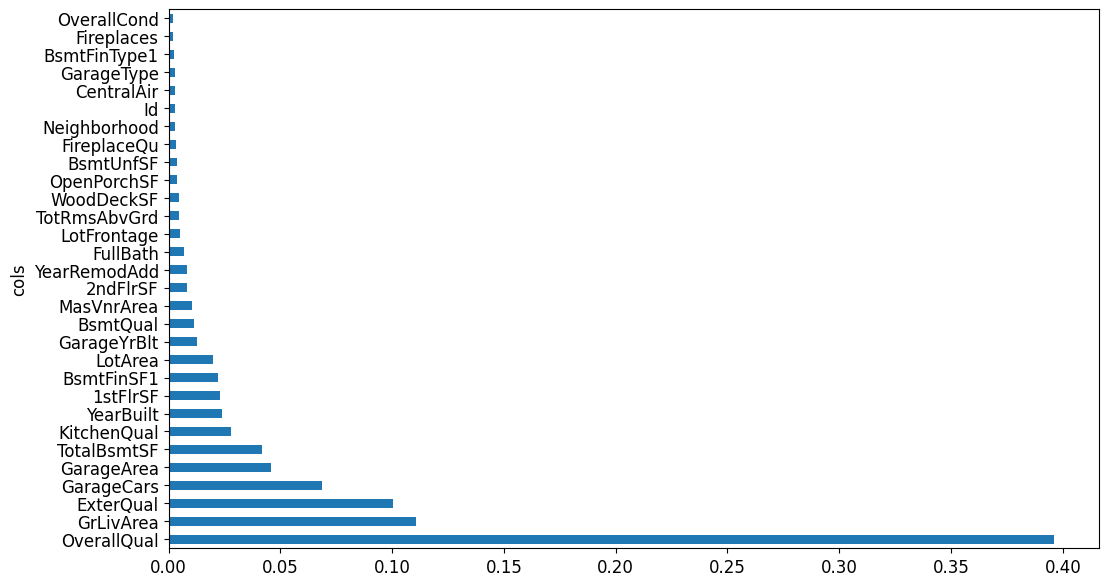

In [227]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Lets remove low importance variables

In [233]:
fi[fi["cols"]=="LotFrontage"]

,cols,imp
48,LotFrontage,0.004974


In [242]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

17

In [243]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [244]:
m = rf(xs_imp, y)
print(m_rmse(m,xs_imp,y))
print(m_rmse(m,valid_xs_imp,valid_y))
# minimal degradation in results

27061
33823


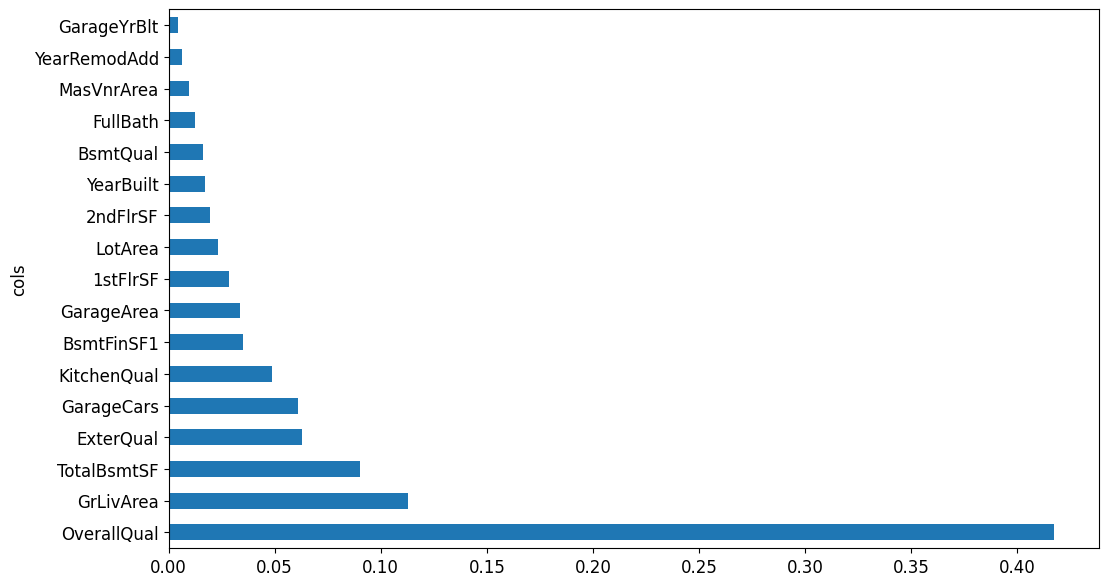

In [245]:
plot_fi(rf_feat_importance(m, xs_imp));

## Remove Redundant Features

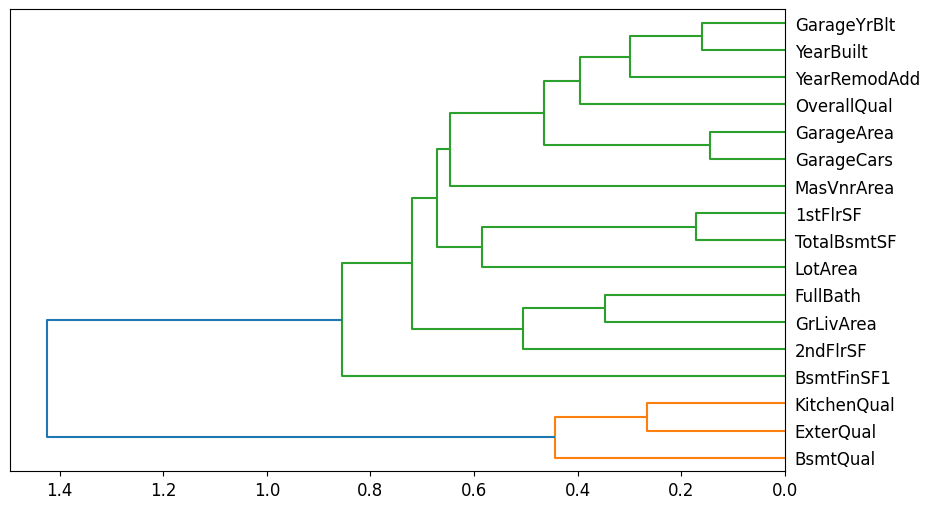

In [246]:
cluster_columns(xs_imp)

In [248]:
"""
makes sense that garageYrBlt and YearBuiltcorrelate becasue the garage is mostlikely built the same year as the house
Additionally, garage area should correlate to more garagecars that can fit
1stFlrSF should correlate to TotalBsmtSF because most 1StFlrs are build directly above the basement plan
"""

'\nmakes sense that garageYrBlt and YearBuiltcorrelate becasue the garage is mostlikely built the same year as the house\nAdditionally, garage area should correlate to more garagecars that can fit\n1stFlrSF should correlate to TotalBsmtSF because most 1StFlrs are build directly above the basement plan\n'

In [249]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=600, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [250]:
# drop variables to see effect
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    '1stFlrSF', "TotalBsmtSF", "GarageArea", "GarageCars", "GarageYrBlt", "YearBuilt")}

{'1stFlrSF': 0.8147207537302461,
 'TotalBsmtSF': 0.8107677657523285,
 'GarageArea': 0.8075836908624503,
 'GarageCars': 0.8155536599918817,
 'GarageYrBlt': 0.8132796801745086,
 'YearBuilt': 0.815596885395169}

In [251]:
# drop multile at once
# drop a varaible from each of the tightly related pairs
to_drop = [ "TotalBsmtSF", "GarageCars", "GarageYrBlt"]
get_oob(xs_imp.drop(to_drop, axis=1))

0.8113238822101105

In [252]:
# save these
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [253]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(28518, 35470)

## Check Partial Dependence
This is the effect on the prediction of changes one feature at a time

TypeError: PartialDependenceDisplay.__init__() missing 2 required keyword-only arguments: 'target_idx' and 'deciles'

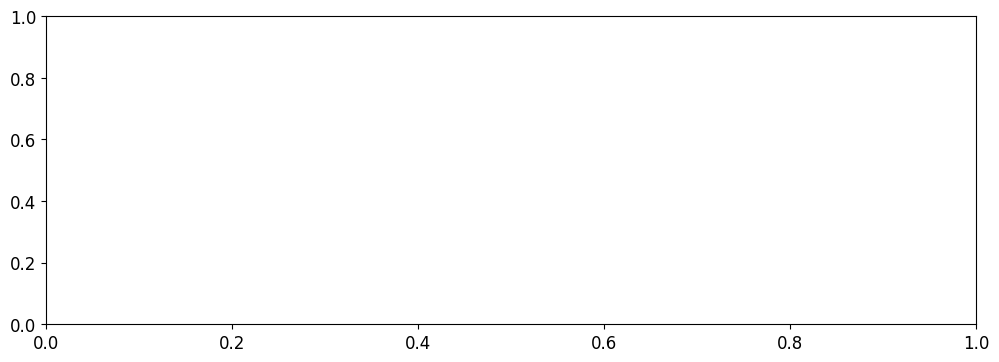

In [269]:
# lets focus on two most important variables
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
results = partial_dependence(m, valid_xs_final,['OverallQual','GrLivArea'])
PartialDependenceDisplay([results], features=valid_xs_final,feature_names=['OverallQual','GrLivArea'])

In [256]:
! pip install scikit-learn

## Find out of Domain data
use random forest to predict wether  data is in vlaidation or training set. it should not be able to predict

In [270]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
1,GrLivArea,0.141493
8,LotArea,0.133853
6,1stFlrSF,0.131854
7,BsmtFinSF1,0.130258
3,GarageArea,0.119544
12,YearRemodAdd,0.089122
